In [1]:
import os
os.chdir('/cluster/home/bdayan/girgs/benji_src/notebooks/')

In [2]:
import sys
sys.path.append('../')
sys.path.append('../../nemo-eva/src/')

import os
os.getcwd()



'/cluster/home/bdayan/girgs/benji_src/notebooks'

In [3]:
from benji_girgs import utils, generation, points, fitting, mcmc
import os
import glob
import pandas as pd
import networkit

import networkit as nk

from girg_sampling import girgs

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "last"

import numpy as np
import matplotlib.pyplot as plt

import do_feature_extract
import networkx as nx


/cluster/scratch/bdayan/GIRG_data/socfb-Caltech36.SpaceOne
/cluster/scratch/bdayan/GIRG_data/socfb-Reed98.SpaceOne
/cluster/scratch/bdayan/GIRG_data/socfb-Haverford76.SpaceOne
/cluster/scratch/bdayan/GIRG_data/socfb-Simmons81.SpaceOne
/cluster/scratch/bdayan/GIRG_data/socfb-Swarthmore42.SpaceOne
/cluster/scratch/bdayan/GIRG_data/socfb-Amherst41.SpaceOne
/cluster/scratch/bdayan/GIRG_data/socfb-Bowdoin47.SpaceOne
/cluster/scratch/bdayan/GIRG_data/socfb-Hamilton46.SpaceOne
/cluster/scratch/bdayan/GIRG_data/socfb-Trinity100.SpaceOne
/cluster/scratch/bdayan/GIRG_data/socfb-USFCA72.SpaceOne
/cluster/scratch/bdayan/GIRG_data/socfb-Williams40.SpaceOne
/cluster/scratch/bdayan/GIRG_data/socfb-Oberlin44.SpaceOne
/cluster/scratch/bdayan/GIRG_data/socfb-Wellesley22.SpaceOne
/cluster/scratch/bdayan/GIRG_data/socfb-Smith60.SpaceOne
/cluster/scratch/bdayan/GIRG_data/socfb-Vassar85.SpaceOne
/cluster/scratch/bdayan/GIRG_data/socfb-Middlebury45.SpaceOne
/cluster/scratch/bdayan/GIRG_data/socfb-Pepperdine8

In [5]:
import os
os.getcwd()
os.environ['DATA_PATH'] = '../../FE_FB_Torus_with_mixed/'

df = pd.read_csv(os.environ['DATA_PATH'] + '2-features/results.csv')

df.Info = df.Info.apply(lambda temp: {key: eval(var) for key, var in [x.split('=') for x in temp.split('|')]} if (type(temp) is str and '|' in temp) else {
    })
df['alpha'] = df.Info.apply(lambda x: x['alpha'] if 'alpha' in x else 1/float(x['t']) if 't' in x else None)

In [7]:
df.loc[df.Model == '1d-girg', ['Graph', 'Model', 'Nodes', 'Info']]

,Graph,Model,Nodes,Info
35,socfb-Bowdoin47,1d-girg,2250,"{'tau': 5.797840767000196, 'alpha': 1.34228187..."
37,socfb-Amherst41,1d-girg,2235,"{'tau': 5.642546890477902, 'alpha': 1.38498160..."
38,socfb-nips-ego,1d-girg,1739,"{'tau': 2.1, 'alpha': 1.0101010101010102, 'con..."
54,socfb-Brandeis99,1d-girg,3887,"{'tau': 4.980891324695106, 'alpha': 1.32190436..."
64,socfb-American75,1d-girg,6370,"{'tau': 4.849201442177161, 'alpha': 1.29567770..."
...,...,...,...,...
1162,socfb-UIllinois,1d-girg,30795,"{'tau': 5.555904261831289, 'alpha': 1.30213631..."
1169,socfb-UPenn7,1d-girg,14888,"{'tau': 5.894653922952865, 'alpha': 1.27668063..."
1171,socfb-UIllinois20,1d-girg,30795,"{'tau': 5.555904261831289, 'alpha': 1.30213631..."
1173,socfb-UGA50,1d-girg,24380,"{'tau': 5.76561006763966, 'alpha': 1.282950786..."


## alpha and average degree are the key things to see, across different d GIRGs

In [28]:
a = df.loc[df.Model == '1d-girg']
a['avg_deg'] = 2 * a['Edges'] / a['Nodes']
a.loc[:, ['Nodes', 'Edges', 'alpha']]

/scratch/tmp.18423590.bdayan/ipykernel_67444/372111713.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  a['avg_deg'] = 2 * a['Edges'] / a['Nodes']


,Nodes,Edges,alpha
35,2250,84195,1.342282
37,2235,90814,1.384982
38,1739,2872,1.010101
54,3887,138169,1.321904
64,6370,217845,1.295678
...,...,...,...
1162,30795,1265528,1.302136
1169,14888,686790,1.276681
1171,30795,1265528,1.302136
1173,24380,1175720,1.282951


array([[<AxesSubplot: title={'center': 'alpha'}>]], dtype=object)

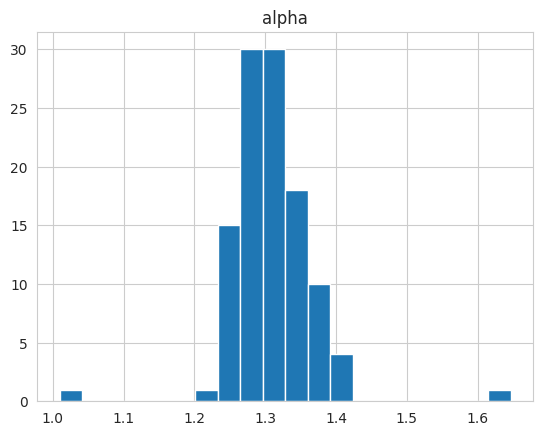

In [15]:
a.hist(column='alpha', bins=20)

array([[<AxesSubplot: title={'center': 'avg_deg'}>]], dtype=object)

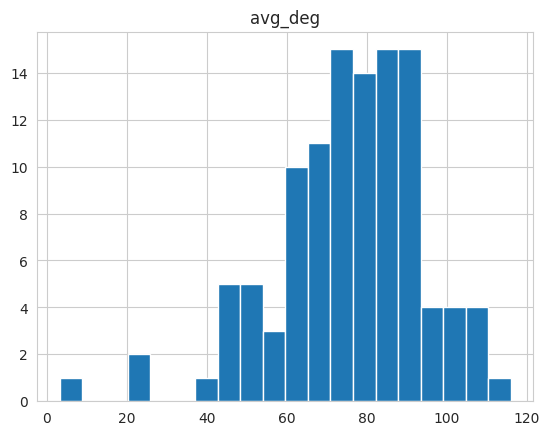

In [16]:
a.hist(column='avg_deg', bins=20)

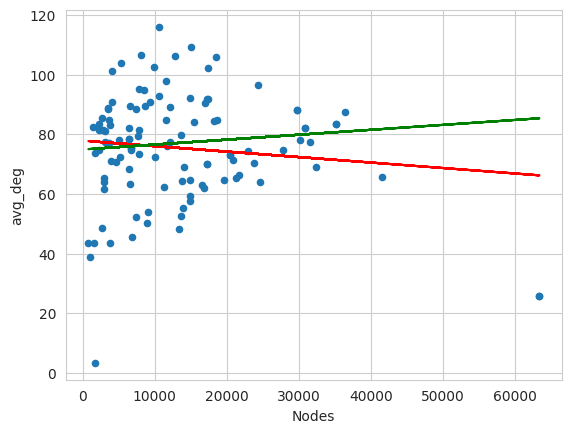

In [25]:
a.plot.scatter('Nodes', 'avg_deg')
p, q = np.polyfit(a['Nodes'], a['avg_deg'], 1)
p2, q2 = np.polyfit(a.loc[a.avg_deg > 30, 'Nodes'], a.loc[a.avg_deg > 30, 'avg_deg'], 1)
plt.plot(a['Nodes'], p*a['Nodes'] + q, color='r')
### Green line is removing the two outliers
plt.plot(a['Nodes'], p2*a['Nodes'] + q2, color='g')

In [29]:
a['Effect']

Index(['Centrality.Betweenness.Binning.Number CDF',
       'Centrality.Betweenness.Binning.Number Histogram',
       'Centrality.Betweenness.Dispersion.Coefficient Of Variation',
       'Centrality.Betweenness.Dispersion.Coefficient Of Variation (Rank)',
       'Centrality.Betweenness.Dispersion.Interquartile Range',
       'Centrality.Betweenness.Dispersion.Sample Range',
       'Centrality.Betweenness.Dispersion.Standard Deviation',
       'Centrality.Betweenness.Dispersion.Standard Deviation (Rank)',
       'Centrality.Betweenness.Dispersion.Uncorrected Coefficient Of Variation',
       'Centrality.Betweenness.Dispersion.Uncorrected Coefficient Of Variation (Rank)',
       ...
       'Partition.CoreDecomposition.Properties.Bessel's Correction',
       'Partition.CoreDecomposition.Properties.Size',
       'Partition.CoreDecomposition.Shape.Kurtosis',
       'Partition.CoreDecomposition.Shape.Skewness M',
       'Partition.CoreDecomposition.Shape.Skewness YP', 'Self Loops', 'Type',
  

array([[<AxesSubplot: title={'center': 'Effective Diameter'}>]],
      dtype=object)

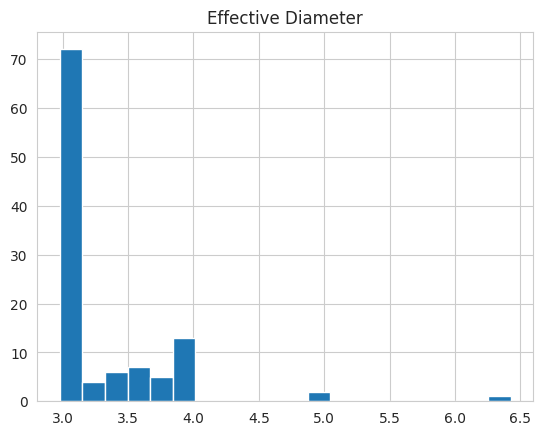

In [34]:
a.hist('Effective Diameter', bins=20)

/scratch/tmp.18423590.bdayan/ipykernel_67444/2446430717.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  a['avg_deg'] = 2 * a['Edges'] / a['Nodes']


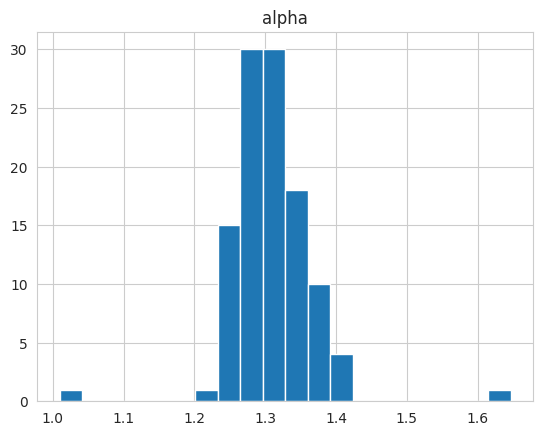

<Figure size 640x480 with 0 Axes>

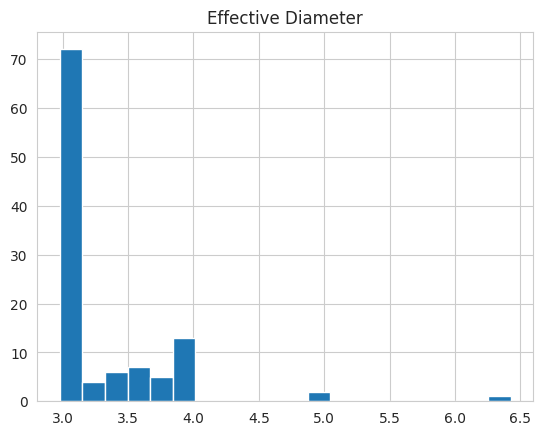

<Figure size 640x480 with 0 Axes>

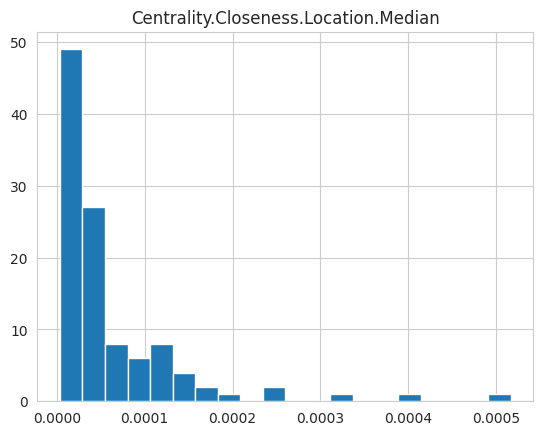

<Figure size 640x480 with 0 Axes>

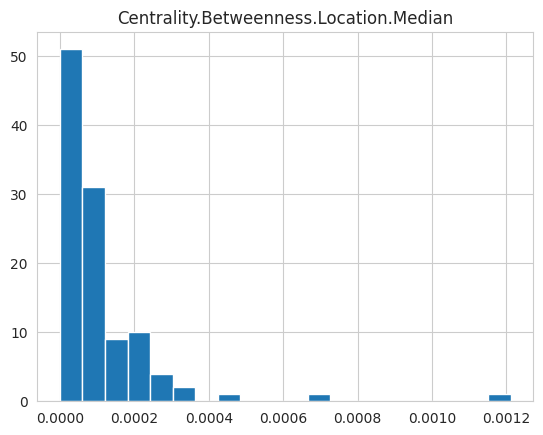

In [51]:
def do_analysis(a):

    a['avg_deg'] = 2 * a['Edges'] / a['Nodes']

    a.hist(column='alpha', bins=20)

    # plt.figure()
    # a.hist(column='avg_deg', bins=20)

    # plt.figure()
    # a.plot.scatter('Nodes', 'avg_deg')
    # p, q = np.polyfit(a['Nodes'], a['avg_deg'], 1)
    # p2, q2 = np.polyfit(a.loc[a.avg_deg > 30, 'Nodes'], a.loc[a.avg_deg > 30, 'avg_deg'], 1)
    # plt.plot(a['Nodes'], p*a['Nodes'] + q, color='r')
    # # ### Green line is removing the two outliers
    # # plt.plot(a['Nodes'], p2*a['Nodes'] + q2, color='g')

    plt.figure()
    a.hist('Effective Diameter', bins=20)

    plt.figure()
    a.hist('Centrality.Closeness.Location.Median', bins=20)

    plt.figure()
    a.hist( 'Centrality.Betweenness.Location.Median', bins=20)

do_analysis(df.loc[df.Model == '1d-girg'])

/scratch/tmp.18423590.bdayan/ipykernel_67444/2446430717.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  a['avg_deg'] = 2 * a['Edges'] / a['Nodes']


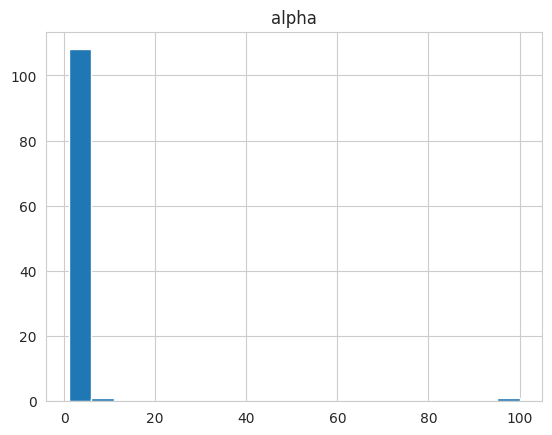

<Figure size 640x480 with 0 Axes>

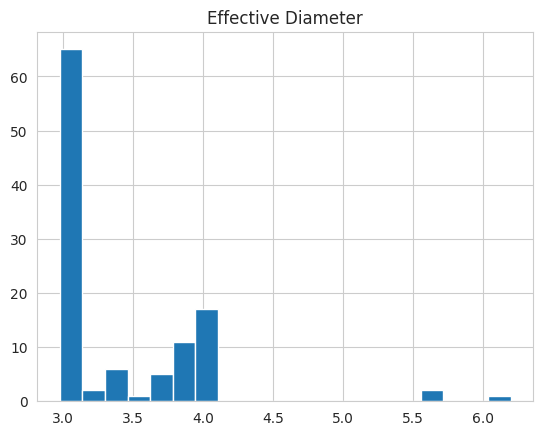

<Figure size 640x480 with 0 Axes>

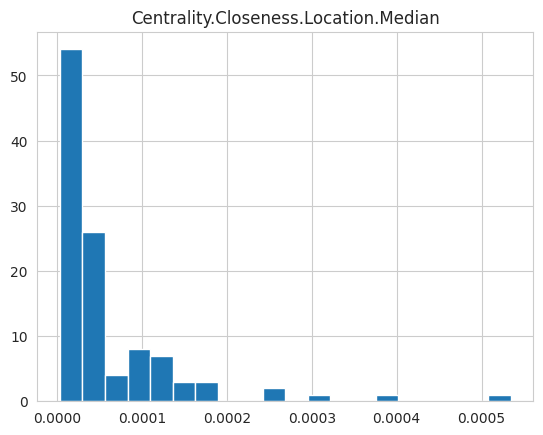

<Figure size 640x480 with 0 Axes>

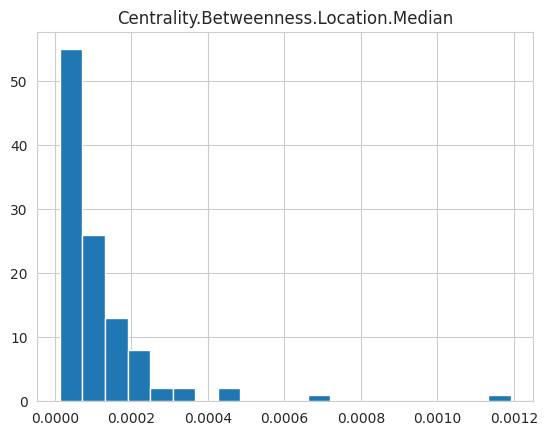

In [52]:
do_analysis(df.loc[df.Model == '4d-girg'])

In [45]:
list(filter(lambda x: 'Centrality' in x, a.columns))

['Centrality.Betweenness.Binning.Number CDF',
 'Centrality.Betweenness.Binning.Number Histogram',
 'Centrality.Betweenness.Dispersion.Coefficient Of Variation',
 'Centrality.Betweenness.Dispersion.Coefficient Of Variation (Rank)',
 'Centrality.Betweenness.Dispersion.Interquartile Range',
 'Centrality.Betweenness.Dispersion.Sample Range',
 'Centrality.Betweenness.Dispersion.Standard Deviation',
 'Centrality.Betweenness.Dispersion.Standard Deviation (Rank)',
 'Centrality.Betweenness.Dispersion.Uncorrected Coefficient Of Variation',
 'Centrality.Betweenness.Dispersion.Uncorrected Coefficient Of Variation (Rank)',
 'Centrality.Betweenness.Dispersion.Uncorrected Standard Deviation',
 'Centrality.Betweenness.Dispersion.Uncorrected Standard Deviation (Rank)',
 'Centrality.Betweenness.Dispersion.Uncorrected Variance',
 'Centrality.Betweenness.Dispersion.Uncorrected Variance (Rank)',
 'Centrality.Betweenness.Dispersion.Variance',
 'Centrality.Betweenness.Dispersion.Variance (Rank)',
 'Centralit

In [50]:
a.loc[:, 'Centrality.Betweenness.Location.Median']

35      0.000317
37      0.000260
38      0.000000
54      0.000175
64      0.000119
          ...   
1162    0.000022
1169    0.000051
1171    0.000022
1173    0.000029
1178    0.000043
Name: Centrality.Betweenness.Location.Median, Length: 110, dtype: float64

array([[<AxesSubplot: title={'center': 'Centrality.Closeness.Location.Median'}>]],
      dtype=object)

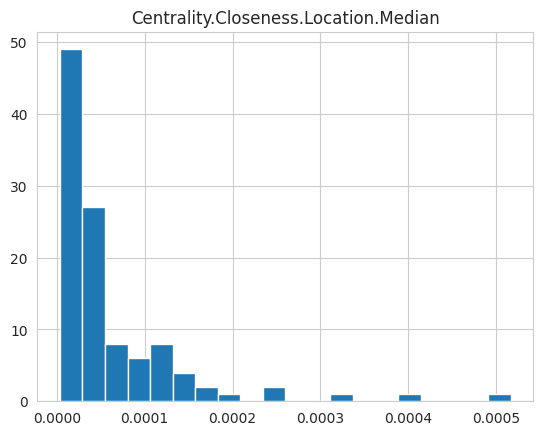

In [48]:
a.hist('Centrality.Closeness.Location.Median', bins=20)

array([[<AxesSubplot: title={'center': 'Centrality.Closeness.Dispersion.Standard Deviation'}>]],
      dtype=object)

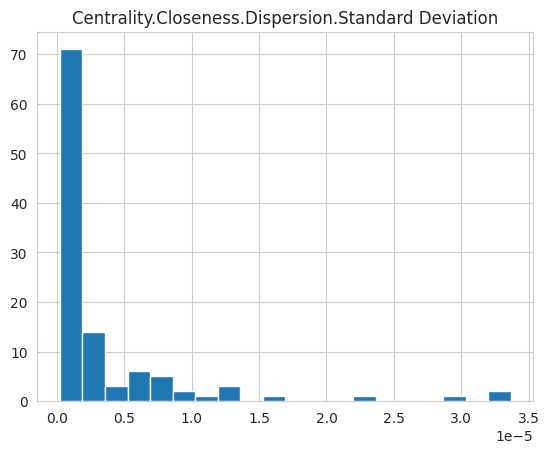

In [64]:
df.loc[df.Model == '1d-girg'].hist('Centrality.Closeness.Dispersion.Standard Deviation', bins=20)

array([[<AxesSubplot: title={'center': 'Centrality.Closeness.Dispersion.Standard Deviation'}>]],
      dtype=object)

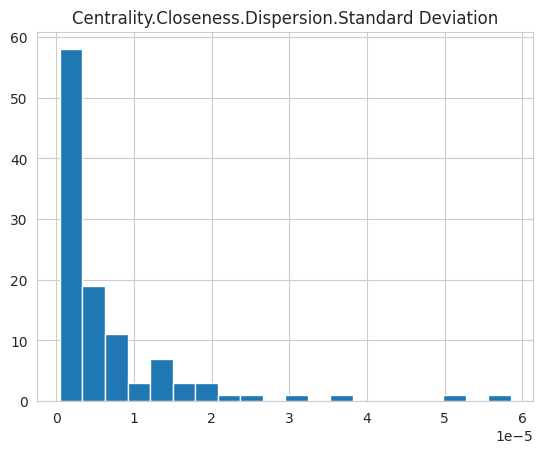

In [66]:
df.loc[df.Model == 'real-world'].hist('Centrality.Closeness.Dispersion.Standard Deviation', bins=20)